# Gillespie Implementation using Pyro

In [257]:
import pyro
import torch

import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

## Generate Data

In [746]:
def model(num_time_steps):
    
    """
    Model to generate data in pyro with known rates.
    """
    
    batch = torch.tensor([[0.,0.,0.]] * num_time_steps)
    
    ## Latent model parameters. Interested in infering rate
    with pyro.plate("starting_params"):
        rates = torch.tensor([.7, .1, .9])
        
    
    with pyro.plate("data") as i:
        
        #s_start = pyro.sample("s_start", pyro.distributions.Normal(10, 0.01).expand([3]).to_event(1))
        s_start = torch.tensor([10., 10., 10.])
        batch[0] = torch.tensor(s_start)
        
        for t in range(1, num_time_steps):

            ## Gillespie sampling
            #with pyro.plate("latent_discrete"):
            sample = pyro.sample("sample_{0}_{1}".format(str(t), str(i)), 
                                     pyro.distributions.Categorical(
                                         torch.tensor(s_start * rates)))

            ## Update species
            update = torch.zeros(3)
            update[sample] = 1
            s_temp = pyro.sample(f"s_{t}", 
                                 pyro.distributions.Normal(s_start + update, .01).to_event(1))
            batch[t] = torch.tensor(s_temp)
            
            s_start = s_temp
            
    return batch


In [747]:
data = list()
for x in range(100):
    temp = model(100)
    data.append(temp)
data = torch.stack(data)

/tmp/ipykernel_317/3649669108.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch[0] = torch.tensor(s_start)
/tmp/ipykernel_317/3649669108.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s_start * rates)))
/tmp/ipykernel_317/3649669108.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch[t] = torch.tensor(s_temp)


#### Save Data|

In [435]:
with open('data/test_data.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Confirm rates make sense

(array([  6.,  32., 122., 220., 236., 183., 126.,  51.,  19.,   5.]),
 array([14.970642, 21.781897, 28.593151, 35.404408, 42.21566 , 49.026917,
        55.838173, 62.649426, 69.46068 , 76.271935, 83.08319 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

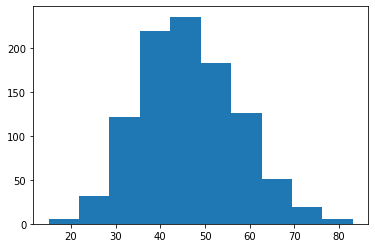

In [431]:
fig, ax = plt.subplots()

ax.hist(np.array(data[:, 99, 0]), bins = 10)

(array([  4.,  17.,  42., 100., 189., 247., 220., 134.,  38.,   9.]),
 array([ 32.04176 ,  38.960445,  45.87913 ,  52.797817,  59.716503,
         66.635185,  73.55387 ,  80.47256 ,  87.39124 ,  94.30993 ,
        101.228615], dtype=float32),
 <BarContainer object of 10 artists>)

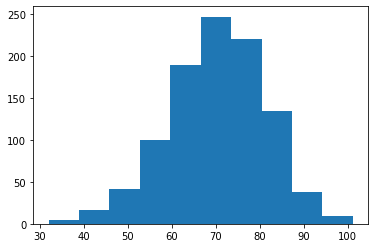

In [432]:
fig, ax = plt.subplots()

ax.hist(np.array(data[:, 99, 2]), bins = 10)

## Define Model used for Inference

In [649]:
pyro.sample("r1", pyro.distributions.Delta(torch.tensor(.1)))

tensor(0.1000)

In [713]:
data = data[:, :99, :]

In [760]:
def model(data):
    
    """
    Pyro model implementing Gillespie sampling with latent rates and categorical sampling.
    """
    
    ## Latent model parameters. Interested in infering rate
    with pyro.plate("starting_params"):
        ## Rate parameter
        r1 = pyro.sample("r1", pyro.distributions.Normal(torch.tensor(.4), torch.tensor(.1)))
        r2 = pyro.sample("r2", pyro.distributions.Normal(torch.tensor(.2), torch.tensor(.05)))
        r3 = pyro.sample("r3", pyro.distributions.Normal(torch.tensor(.9), torch.tensor(.1)))
    
    ## starting points
    #s_start = pyro.sample("s_start", pyro.distributions.Normal(10, 0.01).expand([3]).to_event(1))
    s_start = torch.tensor([10., 10., 10.])

    ## Loop over each observed trace
    with pyro.plate("sequences", data.shape[0]):
        
        ## Each step in trace
        for t in pyro.markov(torch.arange(data.shape[1])):
            # latent categorical sample
            sample = pyro.sample(f"sample_{t}", 
                                 pyro.distributions.Categorical(s_start * torch.tensor([r1, r2, r3])),
                                 infer={"enumerate": "parallel"})
            
            ## Latent species step change
            update = torch.zeros(3)
            update[sample] = 1
            s_update = s_start + update
            
            ## Observed trace
            s_obs = pyro.sample(f"s_{t}", 
                                 pyro.distributions.Normal(s_start + update, .01).to_event(1), 
                                 obs=data[:, t])
            s_start = s_update
        


### MCMC Inference

In [ ]:
nuts_kernel = pyro.infer.NUTS(model)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=1000)
mcmc.run(data)
samples = mcmc.get_samples()

Sample:  59%|███████████████████████▋                | 1187/2000 [28:24,  6.48s/it, step size=4.11e-02, acc. prob=1.000]

In [493]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        r1      0.58      0.18      0.48      0.40      0.80    126.46      0.99
        r2      0.20      0.18      0.21      0.00      0.40    110.12      0.99
        r3      0.72      0.22      0.60      0.50      1.00    183.16      1.00

Number of divergences: 0


### HMC

### Variational Inference

In [373]:
def guide(data):
    
    ## Latent model parameters. Interested in infering rate
    rate0 = pyro.param("rate0", torch.tensor(.
    r1 = pyro.sample("r1", pyro.distributions.Uniform(.4, .8))
    r2 = pyro.sample("r2", pyro.distributions.Uniform(0, .4))
    r3 = pyro.sample("r3", pyro.distributions.Uniform(.5, 1))
    
    ## starting points
    s_start = pyro.sample("s_start", pyro.distributions.Normal(10, 0.01).expand([3]).to_event(1))
    #s_start = torch.tensor([10., 10., 10.])

    ## Loop over each observed trace
    with pyro.plate("sequences", data.shape[0]):
        
        ## Each step in trace
        for t in pyro.markov(range(1, data.shape[1])):
            # latent categorical sample
            pyro.sample(f"sample_{t}", 
                                 pyro.distributions.Categorical(s_start * rates),
                                 infer={"enumerate": "parallel"})

SyntaxError: invalid syntax (257577028.py, line 4)

In [598]:
hmm_guide = pyro.infer.autoguide.AutoNormal(pyro.poutine.block(model, expose=["r1", "r2", "r3"]))

In [599]:
# set up the optimizer
adam_params = {"lr": 0.05}#, "betas": (0.90, 0.999)}

# def per_param_callable(param_name):
#     if param_name == 'rate':
#         return {"lr": 0.01}
#     else:
#         return {"lr": 0.001}

optimizer = pyro.optim.Adam(adam_params)
# guide = pyro.infer.autoguide.AutoGuide(pyro.poutine.block(model, expose=["s_start", "r1"]))
           #hide=["sample_{0}".format(str(x)) for x in range(100)]))#, hide=['sample_0_0'])
#guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

# setup the inference algorithm
svi = pyro.infer.SVI(model, hmm_guide, optimizer, loss=pyro.infer.TraceEnum_ELBO())

n_steps = 500
pyro.clear_param_store()
# do gradient steps
for step in range(n_steps):
    loss = svi.step(data)
    if step % 10 == 0:
        print("[iteration %04d] loss: %.4f" % (step + 1, loss / len(data)))
        #print(pyro.param('rate'))


ValueError: Expected parameter probs (Tensor of shape (3,)) of distribution Categorical(probs: torch.Size([3])) to satisfy the constraint Simplex(), but found invalid values:
tensor([nan, nan, nan])
Trace Shapes:  
 Param Sites:  
Sample Sites:  
      r1 dist |
        value |
      r2 dist |
        value |
      r3 dist |
        value |
Trace Shapes:
 Param Sites:
Sample Sites:

In [620]:
pyro.sample("transition", pyro.distributions.Dirichlet(torch.tensor([])))

tensor([0.9424, 0.0576])

In [731]:
hmm_guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(model, expose=["r1", "r2", "r3"]))
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)
svi = pyro.infer.SVI(model, hmm_guide, optimizer, loss=elbo)

n_steps = 500
pyro.clear_param_store()
# do gradient steps
for step in range(n_steps):
    loss = svi.step(data)
    if step % 10 == 0:
        print("[iteration %04d] loss: %.4f" % (step + 1, loss / len(data)))

RuntimeError: upper bound and larger bound inconsistent with step sign
Trace Shapes:
 Param Sites:
 AutoDelta.r1
 AutoDelta.r2
 AutoDelta.r3
Sample Sites:
Trace Shapes:
 Param Sites:
 AutoDelta.r1
 AutoDelta.r2
 AutoDelta.r3
Sample Sites:

### MAP/MLE

In [737]:
def train(model, guide, lr=0.005, n_steps=201):
    pyro.clear_param_store()
    adam = pyro.optim.Adam({"lr": lr})
    svi = pyro.infer.SVI(model, guide, adam, loss=pyro.infer.TraceEnum_ELBO())

    for step in range(n_steps):
        loss = svi.step(data)
        if step % 50 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))

In [741]:
def guide_map(data):
    
    ## Latent model parameters. Interested in infering rate
    with pyro.plate("starting_params"):
    ## Rate parameter
    # rate0 = pyro.param("rate", torch.tensor(.5),
    #                   constraint=pyro.distributions.constraints.positive)

        r1 = pyro.sample("r1", pyro.distributions.Normal(torch.tensor(.4), torch.tensor(.1)))
        r2 = pyro.sample("r2", pyro.distributions.Normal(torch.tensor(.2), torch.tensor(.05)))
        r3 = pyro.sample("r3", pyro.distributions.Normal(torch.tensor(.9), torch.tensor(.1)))
    # rates = pyro.sample("rates", pyro.distributions.Uniform(0, 1).expand([3]).to_event(1))
    # rates = torch.tensor([r1, r2, r3])
    
    ## starting points
    #s_start = pyro.sample("s_start", pyro.distributions.Normal(10, 0.01).expand([3]).to_event(1))
    s_start = torch.tensor([10., 10., 10.])

    ## Loop over each observed trace
    with pyro.plate("sequences", data.shape[0]):
        
        ## Each step in trace
        for t in pyro.markov(torch.arange(data.shape[1])):
            # latent categorical sample

            sample = pyro.sample(f"sample_{t}", 
                                 pyro.distributions.Categorical(s_start * torch.tensor([r1, r2, r3])),
                                 infer={"enumerate": "parallel"})

            ## Observed trace
            update = torch.zeros(3)
            update[sample] = 1
            s_temp = pyro.sample(f"s_{t}", 
                                 pyro.distributions.Normal(s_start + update, .01).to_event(1), 
                                 obs=data[:, t])

            s_start = s_temp


In [759]:
autoguide_mle = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(model, expose=["r1", "r2", "r3"]))
train(model, autoguide_mle)

RuntimeError: upper bound and larger bound inconsistent with step sign
Trace Shapes:
 Param Sites:
 AutoDelta.r1
 AutoDelta.r2
 AutoDelta.r3
Sample Sites:

In [585]:
train(model_mle, guide_mle)

[iter 0]  loss: 998098432.0000
[iter 50]  loss: 998098432.0000
[iter 100]  loss: 998098432.0000
[iter 150]  loss: 998098432.0000
[iter 200]  loss: 998098432.0000
